# SWMAL Exercise


## Hyperparameters and Gridsearch 

When instantiating a Scikit-learn model in python most or all constructor parameters have _default_ values. These values are not part of the internal model and are hence called ___hyperparameters___---in contrast to _normal_ model parameters, for example the neuron weights, $\mathbf w$, for an `MLP` model.

### Manual Tuning Hyperparameters

Below is an example of the python constructor for the support-vector classifier `sklearn.svm.SVC`, with say the `kernel` hyperparameter having the default value `'rbf'`. If you should choose, what would you set it to other than `'rbf'`? 

```python
class sklearn.svm.SVC(
    C=1.0, 
    kernel=’rbf’, 
    degree=3,
    gamma=’auto_deprecated’, 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight=None, 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape=’ovr’, 
    random_state=None
  )
```  

The default values might be a sensible general starting point, but for your data, you might want to optimize the hyperparameters to yield a better result. 

To be able to set `kernel` to a sensible value you need to go into the documentation for the `SVC` and understand what the kernel parameter represents, and what values it can be set to, and you need to understand the consequences of setting `kernel` to something different than the default...and the story repeats for every other hyperparameter!

### Brute Force  Search

An alternative to this structured, but time-consuming approach, is just to __brute-force__ a search of interesting hyperparameters, and  choose the 'best' parameters according to a fit-predict and some score, say 'f1'. 

<img src="https://itundervisning.ase.au.dk/SWMAL/L09/Figs/gridsearch.png"  alt="WARNING: could not get image from server."  style="width:350px">
<small><em>
    <center> Conceptual graphical view of grid search for two distinct hyperparameters. </center> 
    <center> Notice that you would normally search hyperparameters like `alpha` with an exponential range, say [0.01, 0.1, 1, 10] or similar.</center>
</em></small>

Now, you just pick out some hyperparameters, that you figure are important, set them to a suitable range, say

```python
    'kernel':('linear', 'rbf'), 
    'C':[1, 10]
```
and fire up a full (grid) search on this hyperparameter set, that will try out all your specified combination of `kernel` and `C` for the model, and then prints the hyperparameter set with the highest score...

The demo code below sets up some of our well known 'hello-world' data and then run a _grid search_ on a particular model, here a _support-vector classifier_ (SVC)

Other models and datasets  ('mnist', 'iris', 'moon') can also be examined.

### Qa Explain GridSearchCV

There are two code cells below: 1) function setup, 2) the actual grid-search.

Review the code cells and write a __short__ summary. Mainly focus on __cell 2__, but dig into cell 1 if you find it interesting (notice the use of local-function, a nifty feature in python).
  
In detail, examine the lines:  
  
```python
grid_tuned = GridSearchCV(model, tuning_parameters, ..
grid_tuned.fit(X_train, y_train)
..
FullReport(grid_tuned , X_test, y_test, time_gridsearch)
```
and write a short description of how the `GridSeachCV` works: explain how the search parameter set is created and the overall search mechanism is functioning (without going into too much detail).

What role does the parameter `scoring='f1_micro'` play in the `GridSearchCV`, and what does `n_jobs=-1` mean? 

In [1]:
from time import time
import numpy as np
import sys
sys.path.append("../")

from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets

from libitmal import dataloaders as itmaldataloaders # Needed for load of iris, moon and mnist
import matplotlib.pyplot as plt

currmode="N/A" # GLOBAL var!

def SearchReport(model): 
    
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            ret_str=""          
            for key in sorted(best_params):
                value = best_params[key]
                temp_str = "'" if str(type(value))=="<class 'str'>" else ""
                if len(ret_str)>0:
                    ret_str += ','
                ret_str += f'{key}={temp_str}{value}{temp_str}'  
            return ret_str          
        try:
            param_str = GetParams(best_params)
            return type(model).__name__ + '(' + param_str + ')' 
        except:
            return "N/A(1)"
        
    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        stds  = model.cv_results_['std_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")
    
    global currmode                
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"   
    return f"best: dat={currmode}, score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_ 

def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)                 
    print(classification_report(y_true, y_pred, target_names=target_names))
    print()

def PlotConfusionMatrix(model, X_test, y_test, target_names=None, normalize='true', cmap=plt.cm.Blues):
    """
    Plot confusion matrix for the given model and test data.

    Args:
        model: Trained classifier (must have predict method).
        X_test: Features of the test dataset.
        y_test: True labels of the test dataset.
        target_names: List of label names (optional).
        normalize: Normalization type {'true', 'pred', 'all', None}.
        cmap: Colormap used for the plot.
    """
    print("Plotting confusion matrix...")
    
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize=normalize)
    
    # Create a display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    # Plot the matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=cmap, ax=ax, colorbar=True)
    
    plt.title("Confusion Matrix")
    plt.show()


def FullReport(model, X_test, y_test, t, plot_confusion=False):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)
    
    if plot_confusion:
        target_names = [str(i) for i in sorted(set(y_test))]
        PlotConfusionMatrix(model, X_test, y_test, target_names=target_names)
    
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel

    
def LoadAndSetupData(mode, test_size=0.3):
    assert test_size>=0.0 and test_size<=1.0
    
    def ShapeToString(Z):
        n = Z.ndim
        s = "("
        for i in range(n):
            s += f"{Z.shape[i]:5d}"
            if i+1!=n:
                s += ";"
        return s+")"

    global currmode
    currmode=mode
    print(f"DATA: {currmode}..")
    
    if mode=='moon':
        X, y = itmaldataloaders.MOON_GetDataSet(n_samples=5000, noise=0.2)
        itmaldataloaders.MOON_Plot(X, y)
    elif mode=='mnist':
        X, y = itmaldataloaders.MNIST_GetDataSet(load_mode=0)
        if X.ndim==3:
            X=np.reshape(X, (X.shape[0], -1))
    elif mode=='iris':
        X, y = itmaldataloaders.IRIS_GetDataSet()
    else:
        raise ValueError(f"could not load data for that particular mode='{mode}', only 'moon'/'mnist'/'iris' supported")
        
    print(f'  org. data:  X.shape      ={ShapeToString(X)}, y.shape      ={ShapeToString(y)}')

    assert X.ndim==2
    assert X.shape[0]==y.shape[0]
    assert y.ndim==1 or (y.ndim==2 and y.shape[1]==0)    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, shuffle=True
    )
    
    print(f'  train data: X_train.shape={ShapeToString(X_train)}, y_train.shape={ShapeToString(y_train)}')
    print(f'  test data:  X_test.shape ={ShapeToString(X_test)}, y_test.shape ={ShapeToString(y_test)}')
    print()
    
    return X_train, X_test, y_train, y_test

def TryKerasImport(verbose=True):
    
    kerasok = True
    try:
        import keras as keras_try
    except:
        kerasok = False

    tensorflowkerasok = True
    try:
        import tensorflow.keras as tensorflowkeras_try
    except:
        tensorflowkerasok = False
        
    ok = kerasok or tensorflowkerasok
    
    if not ok and verbose:
        if not kerasok:
            print("WARNING: importing 'keras' failed", file=sys.stderr)
        if not tensorflowkerasok:
            print("WARNING: importing 'tensorflow.keras' failed", file=sys.stderr)

    return ok
    
print(f"OK(function setup" + ("" if TryKerasImport() else ", hope MNIST loads works because it seems you miss the installation of Keras or Tensorflow!") + ")")

OK(function setup)


In [ ]:
methods = ['iris', 'moon']

for method in methods:
    print(f"\n=== Running GridSearch for dataset: {method} ===\n")

    # Load and split the dataset
    X_train, X_test, y_train, y_test = LoadAndSetupData(method, test_size=0.3)

    # Define your model and parameters (example)
    model = svm.SVC()  # or any other model you want
    tuning_parameters = {'kernel': ['linear', 'rbf'], 'C': [1, 10]}

    # Start timing the grid search
    time_start = time()

    # Perform grid search with cross-validation
    grid_tuned = GridSearchCV(model, tuning_parameters, scoring='f1_micro', n_jobs=-1)
    grid_tuned.fit(X_train, y_train)

    # End timing
    time_gridsearch = time() - time_start

    # Generate reports
    FullReport(grid_tuned, X_test, y_test, time_gridsearch)


### Qb Hyperparameter Grid Search using an SDG classifier

Now, replace the `svm.SVC` model with an `SGDClassifier` and a suitable set of the hyperparameters for that model.

You need at least four or five different hyperparameters from the `SGDClassifier` in the search-space before it begins to take considerable compute time doing the full grid search.

So, repeat the search with the `SGDClassifier`, noticing that it may return a result in a few seconds, even for a larges hyperparameter search-space, due to the low dimensionality and low number of samples in the iris dataset (for larger datasets it can run for hours or days!) 

In [ ]:
methods = ['iris', 'moon', 'mnist']

for method in methods:
    print(f"\n=== Running GridSearch for dataset: {method} ===\n")

    X_train, X_test, y_train, y_test = LoadAndSetupData(method, test_size=0.3)

    base_model = SGDClassifier(random_state=42)

    tuning_parameters = {
        'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'optimal', 'adaptive'],
        'eta0': [0.01, 0.1, 1.0],
        'max_iter': [1000, 2000]
    }


    if method == 'mnist':
        tuning_parameters = {
            'loss': ['hinge'],
            'penalty': ['l2'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['optimal'],
            'eta0': [0.01],
            'max_iter': [1000]
        }

    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=tuning_parameters,
        scoring='f1_micro',
        n_jobs=-1,
        cv=5,
        verbose=1
    )

    t0 = time()
    grid_search.fit(X_train, y_train)
    t1 = time() - t0

    beststr, bestmodel = FullReport(grid_search, X_test, y_test, t1, plot_confusion=True)


### Qc Hyperparameter Random  Search using an SDG classifier

Now, add code to run a `RandomizedSearchCV` instead.

<img src="https://itundervisning.ase.au.dk/SWMAL/L09/Figs/randomsearch.png" alt="WARNING: could not get image from server."  style="width:350px" >
<small><em>
    <center> Conceptual graphical view of randomized search for two distinct hyperparameters. </center> 
</em></small>

Use these default parameters for the random search, similar to the default parameters for the grid search

```python
random_tuned = RandomizedSearchCV(
    model, 
    tuning_parameters, 
    n_iter=20, 
    random_state=42, 
    cv=CV, 
    scoring='f1_micro', 
    verbose=VERBOSE, 
    n_jobs=-1
)
```

but with the two new parameters, `n_iter` and `random_state` added. Since the search-type is now random, the `random_state` gives sense, but essential to random search is the new `n_tier` parameter.

So: investigate the `n_iter` parameter...in code and write a conceptual explanation  in text.

Comparison of time (seconds) to complete `GridSearch` versus `RandomizedSearchCV`, does not necessarily give any sense, if your grid search completes in a few seconds (as for the iris tiny-data). You need a search that runs for minutes, hours, or days.

But you could compare the best-tuned parameter set and best scoring for the two methods. Is the random search best model close to the grid search?  

In [ ]:
print(f"\n=== Running GridSearch for Iris ===\n")

X_train, X_test, y_train, y_test = LoadAndSetupData('iris', test_size=0.3)

model = SGDClassifier(random_state=42)

tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'adaptive'],
    'eta0': [0.01, 0.1, 1.0],
    'max_iter': [1000, 2000]
}

random_tuned = RandomizedSearchCV(
    model, 
    tuning_parameters, 
    n_iter=20, 
    random_state=42, 
    cv=5, 
    scoring='f1_micro', 
    verbose=2, 
    n_jobs=-1
)

t0 = time()
random_tuned.fit(X_train, y_train)
t1 = time() - t0

beststr, bestmodel = FullReport(random_tuned, X_test, y_test, t1, plot_confusion=True)



### Qd MNIST Search Quest II

Finally, a search-quest competition: __who can find the best model+hyperparameters for the MNIST dataset?__

You change to the MNIST data by calling `LoadAndSetupData('mnist')`, and this is a completely other ball-game that the iris _tiny-data_: it's much larger (but still far from _big-data_)!

* You might opt for the exhaustive grid search, or use the faster but-less optimal random search...your choice. 

* You are free to pick any classifier in Scikit-learn, even algorithms we have not discussed yet---__except Neural Networks and KNeighborsClassifier!__. 

* Keep the score function at `f1_micro`, otherwise, we will be comparing 'æbler og pærer'. 

* And, you may also want to scale your input data for some models to perform better.

* __REMEMBER__, DO NOT USE any Neural Network models. This also means not to use any `Keras` or `Tensorflow` models...since they outperform most other models, and there are also too many examples on the internet to cut-and-paste from!

Check your result by printing the first _return_ value from `FullReport()` 
```python 
b1, m1 = FullReport(random_tuned , X_test, y_test, time_randomsearch)
print(b1)
```
that will display a result like
```
best: dat=mnist, score=0.90780, model=SGDClassifier(alpha=1.0,eta0=0.0001,learning_rate='invscaling')
```
and paste your currently best model into the message box, for ITMAL group 09 like
```
Grp09: best: dat=mnist, score=0.90780, model=SGDClassifier(alpha=1.0,eta0=0.0001,learning_rate='invscaling')

Grp09: CTOR for best model: SGDClassifier(alpha=1.0, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0001, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
```
              
on Brightspace: "L09: Regularisering, optimering og søgning" | "Qd MNIST Search Quest"

> https://itundervisning.ase.au.dk/itmal_quest/index.php

and, check if your score (for MNIST) is better than the currently best score. Republish if you get a better score than your own previously best. Deadline for submission of scores is the same as the deadline for the O3 journal handin.

Remember to provide an ITMAL group name manually, so we can identify a winner: the 1. st price is  cake! 

For the journal hand-in, report your progress in scoring choosing different models, hyperparameters to search and how you might need to preprocess your data...and note, that the journal will not be accepted unless it contains information about Your results published on the Brightspace 'Search Quest II' page!

--- Performing Exhaustive GridSearchCV around best SVM parameters ---
Parameter grid for GridSearchCV:
{'svm__C': [0.0009, 0.001169364844344011, 0.0014, 0.0017], 'svm__gamma': [0.075, 0.08696451105631693, 0.095]}
DATA: mnist..
  org. data:  X.shape      =(70000;  784), y.shape      =(70000)
  train data: X_train.shape=(49000;  784), y_train.shape=(49000)
  test data:  X_test.shape =(21000;  784), y_test.shape =(21000)


Data loaded.
X_train shape: (49000, 784), y_train shape: (49000,)
X_test shape: (21000, 784), y_test shape: (21000,)

Base pipeline defined:
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('svm', SVC(kernel='poly', random_state=42))])

Starting GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

GridSearchCV completed in 862.82 seconds.

--- GridSearchCV Results ---
Best F1 Score (micro) found during CV: 0.97555
Best parameters found:
{'svm__C': 0.0009, 'svm__gamma

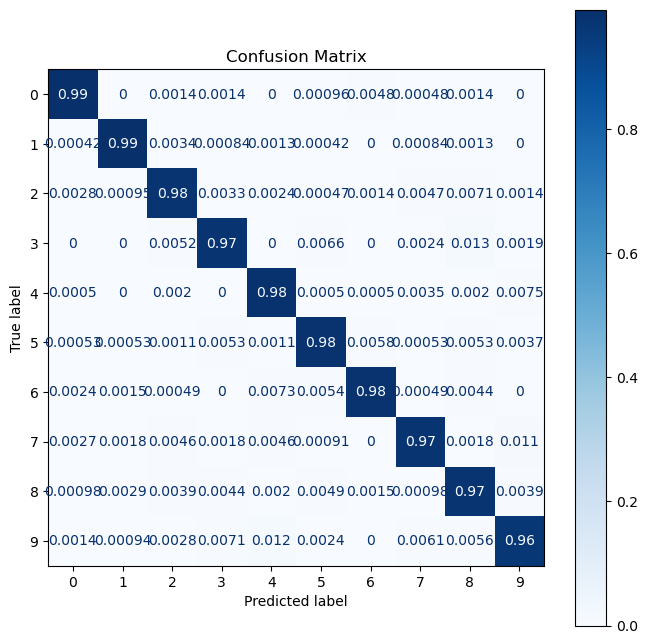

CTOR for best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('svm',
                 SVC(C=0.0009, gamma=0.075, kernel='poly', random_state=42))])

best: dat=mnist, score=0.97555, model=Pipeline(svm__C=0.0009,svm__gamma=0.075)



('best: dat=mnist, score=0.97555, model=Pipeline(svm__C=0.0009,svm__gamma=0.075)',
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('pca', PCA(n_components=0.95, random_state=42)),
                 ('svm',
                  SVC(C=0.0009, gamma=0.075, kernel='poly', random_state=42))]))

In [5]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, f1_score
from time import time
from sklearn.model_selection import GridSearchCV

print("--- Performing Exhaustive GridSearchCV around best SVM parameters ---")

# Best Parameters Found Previously
center_params = {
    'C': 0.001169364844344011,
    'degree': 3,
    'gamma': 0.08696451105631693,
    'kernel': 'poly',
    'pca_n_components': 0.95
}

# Small grid centered around the best values found by RandomizedSearch
param_grid = {
    'svm__C': [0.0009, center_params['C'], 0.0014, 0.0017],
    'svm__gamma': [0.075, center_params['gamma'], 0.095]
}
print("Parameter grid for GridSearchCV:")
print(param_grid)

# Load Data
X_train, X_test, y_train, y_test = LoadAndSetupData('mnist', test_size=0.3)
print("\nData loaded.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Define the base pipeline structure
pipeline_for_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=center_params['pca_n_components'], random_state=42)),
    ('svm', SVC(
        kernel=center_params['kernel'],
        degree=center_params['degree'],
        max_iter=-1,
        random_state=42,
        probability=False
    ))
])

print("\nBase pipeline defined:")
print(pipeline_for_grid)

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_for_grid,
    param_grid=param_grid,
    scoring='f1_micro',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Train using GridSearchCV
print("\nStarting GridSearchCV...")
start_time = time()
grid_search.fit(X_train, y_train)
grid_search_time = time() - start_time
print(f"\nGridSearchCV completed in {grid_search_time:.2f} seconds.")

# Report GridSearch Results
print("\n--- GridSearchCV Results ---")
print(f"Best F1 Score (micro) found during CV: {grid_search.best_score_:.5f}")
print("Best parameters found:")
best_params_found = grid_search.best_params_
print(best_params_found)

# Evaluate Best Model from GridSearch on Test Set
print("\nEvaluating the best model found by GridSearchCV on the test set...")
y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"\n--- Final Test Set Evaluation ---")
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score (micro): {f1_micro:.5f}")
print(f"F1 Score (weighted): {f1_weighted:.5f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nBest Estimator's Pipeline Structure:")
# Access the actual best pipeline configuration
print(grid_search.best_estimator_)

# FullReport
FullReport(grid_search, X_test, y_test, grid_search_time, plot_confusion=True)

REVISIONS||
:-|:-
2018-03-01| CEF, initial.
2018-03-05| CEF, updated.
2018-03-06| CEF, updated and spell checked.
2018-03-06| CEF, major overhaul of functions.
2018-03-06| CEF, fixed problem with MNIST load and Keras.
2018-03-07| CEF, modified report functions and changed Qc+d.
2018-03-11| CEF, updated Qd.
2018-03-12| CEF, added grid and random search figs and added bullets to Qd.
2018-03-13| CEF, fixed SVC and gamma issue, and changed dataload to be in fetchmode (non-keras).
2019-10-15| CEF, updated for ITMAL E19
2019-10-19| CEF, minor text update.
2019-10-23| CEF, changed demo model i Qd) from MLPClassifier to SVC.
2020-03-14| CEF, updated to ITMAL F20.
2020-10-20| CEF, updated to ITMAL E20.
2020-10-27| CEF, type fixes and minor update.
2020-10-28| CEF, added extra journal hand-in specs for Search Quest II, Qd.
2020-10-30| CEF, added non-use of KNeighborsClassifier to Search Quest II, Qd.
2020-11-19| CEF, changed load_mode=2 (Keras) to load_mode=0 (auto) for MNIST loader.
2021-03-17| CEF, updated to ITMAL F21.
2021-10-31| CEF, updated to ITMAL E21.
2021-11-05| CEF, removed iid=True paramter from GridSearchCV(), not present in current version of Scikit-learn (0.24.1).
2022-03-31| CEF, updated to SWMAL F22.
2022-08-30| CEF, updating to v1 changes.
2022-11-04| CEF, updated link to Brightspace, Search Quest II.
2022-11-04| CEF, fixed error "TypeError: classification_report() takes 2 position..".
2022-11-11| CEF, elaborated on Search Quest II deadline.
2023-03-24| CEF, updated link and updated to SWMAL F23.
2024-04-09| CEF, changed text on expected search time for the iris dataset.